# Multitask GP Regression using pymc
Source: https://github.com/GAMES-UChile/mogptk/blob/master/examples/example_gold_oil_NASDAQ_USD.ipynb

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from pymc.sampling_jax import sample_numpyro_nuts
# set the seed
np.random.seed(1)
%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/danh/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/home/danh/WORK/codes/oss/pymc/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


### Set up training data

In [2]:
oil     = pd.read_csv('../data/gonu/brent-daily.csv')
oil.set_index("Date", inplace=True)

gold    = pd.read_csv('../data/gonu/lmba-gold-usd-am-daily.csv')
gold = gold.replace(".", np.nan)
gold.Price = gold.Price.astype(float)
gold.set_index("Date", inplace=True)

nasdaq  = pd.read_csv('../data/gonu/nasdaq.csv')
nasdaq  = nasdaq.rename(columns={"Adj Close":"Price"}) 
nasdaq = nasdaq[["Date", "Price"]]
nasdaq.set_index("Date", inplace=True)

usd     = pd.read_csv('../data/gonu/TWEXB.csv')
usd.set_index("Date", inplace=True)

oil.shape, gold.shape, nasdaq.shape, usd.shape

((8186, 1), (13416, 1), (12249, 1), (1286, 1))

(508, 1) Price    0
dtype: int64
(503, 1) Price    0
dtype: int64
(501, 1) Price    0
dtype: int64
(104, 1) Price    0
dtype: int64


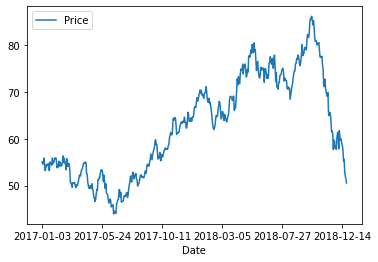

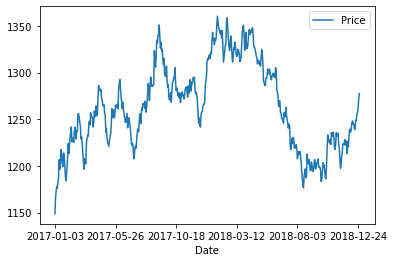

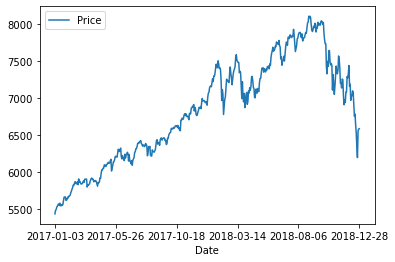

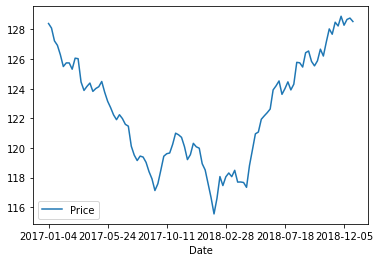

In [9]:
df_list = []
for df in [oil, gold, nasdaq, usd]:
    df = df.loc['2017-01-01':'2018-12-30']
    df = df.dropna()
    df_list.append(df)
    print(df.shape, df.isna().sum())
    df.plot(y="Price")

In [10]:
def build_XY(input_list,output_list=None,index=None):
    num_outputs = len(input_list)
    if output_list is not None:
        assert num_outputs == len(output_list)
        Y = np.vstack(output_list)
    else:
        Y = None

    if index is not None:
        assert len(index) == num_outputs
        I = np.hstack( [np.repeat(j,_x.shape[0]) for _x,j in zip(input_list,index)] )
    else:
        I = np.hstack( [np.repeat(j,_x.shape[0]) for _x,j in zip(input_list,range(num_outputs))] )

    X = np.vstack(input_list)
    X = np.hstack([X,I[:,None]])

    return X,Y,I[:,None]#slices

In [11]:
# X1 = np.random.rand(50, 1) * 8
# X2 = np.random.rand(30, 1) * 5

# # build a suitable set of observed variables
# Y1 = np.sin(X1) + np.random.randn(*X1.shape) * 0.05
# Y2 = np.sin(X2) + np.random.randn(*X2.shape) * 0.05 + 2.0
# X1.shape, X2.shape, Y1.shape, Y2.shape

In [12]:
X, Y, I = build_XY([df.reset_index().index.values[:, None] for df in df_list], 
                   [df.Price.values[:, None] for df in df_list])

In [13]:
type(X), type(Y)

(numpy.ndarray, numpy.ndarray)

In [14]:
X.shape, Y.shape, I.shape

((1616, 2), (1616, 1), (1616, 1))

In [15]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(4,4), initval=np.random.randn(4,4))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=4)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    cov_func = coreg * cov
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, Y, noise=sigma)

/home/danh/WORK/codes/oss/pymc/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


In [ ]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1, target_accept=0.9, init='advi')

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc:Initializing NUTS using advi...


In [18]:
%%time
with model:
    jtrace = sample_numpyro_nuts(500, chains=1, target_accept=0.9)

Compiling...


2022-06-16 14:29:59.194135: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8B (rounded to 256)requested by op 
2022-06-16 14:29:59.194520: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:491] ******************************************************************************xxxxxxxxxxxxxxxxxxxxxx


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 8 bytes.

In [9]:
x_new = np.linspace(-0.5, 1.5, 200)[:, None]
xx_new = np.concatenate((x_new, x_new), axis=0)
idx2 = np.concatenate((np.zeros(200), np.ones(200)))[:, None]
X_new = np.concatenate((xx_new, idx2), axis=1)

with model:
    preds = gp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

/home/danh/WORK/codes/oss/pymc/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


(-4.0, 4.0)

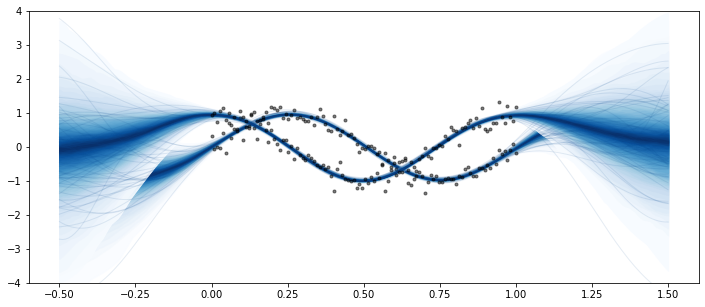

In [10]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
plot_gp_dist(ax, f_pred[:,:200], X_new[:200,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
ax.plot(x, train_y[:,0], 'ok', ms=3, alpha=0.5, label="Data 1");

plot_gp_dist(ax, f_pred[:,200:], X_new[200:,0], palette="Blues", fill_alpha=0.9, samples_alpha=0.1)
ax.plot(x, train_y[:,1], 'ok', ms=3, alpha=0.5, label="Data 2");
ax.set_ylim([-4,4])

In [3]:
train_x = np.linspace(0, 1, 108)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
], -1)

In [4]:
train_x.shape, train_y.shape

((108,), (108, 2))

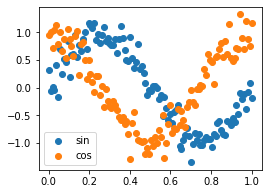

In [5]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
plt.legend(["sin", "cos"])

((108,), (216, 2), (216,))

### Pymc model

In [7]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=2)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    cov_func = coreg * cov
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma)

/tmp/ipykernel_56222/46575181.py:6: FutureWarning: The `testval` argument is deprecated; use `initval`.
  W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))
/home/danh/WORK/codes/oss/pymc/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


In [8]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 148 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


CPU times: user 7min 22s, sys: 12min 14s, total: 19min 36s
Wall time: 2min 34s


In [9]:
x_new = np.linspace(-0.5, 1.5, 200)[:, None]
xx_new = np.concatenate((x_new, x_new), axis=0)
idx2 = np.concatenate((np.zeros(200), np.ones(200)))[:, None]
X_new = np.concatenate((xx_new, idx2), axis=1)

with model:
    preds = gp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

/home/danh/WORK/codes/oss/pymc/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


(-4.0, 4.0)

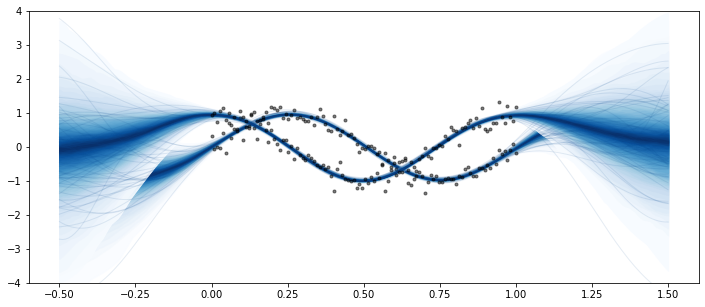

In [10]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
plot_gp_dist(ax, f_pred[:,:200], X_new[:200,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
ax.plot(x, train_y[:,0], 'ok', ms=3, alpha=0.5, label="Data 1");

plot_gp_dist(ax, f_pred[:,200:], X_new[200:,0], palette="Blues", fill_alpha=0.9, samples_alpha=0.1)
ax.plot(x, train_y[:,1], 'ok', ms=3, alpha=0.5, label="Data 2");
ax.set_ylim([-4,4])

In [12]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W[0, 0]",0.056,2.138,-3.758,4.148,0.153,0.110,201.0,166.0,NaN
"W[0, 1]",-0.012,2.146,-3.832,3.914,0.140,0.099,235.0,353.0,NaN
"W[1, 0]",0.104,2.055,-3.751,3.874,0.133,0.094,234.0,215.0,NaN
"W[1, 1]",0.263,2.221,-3.745,4.255,0.171,0.123,174.0,206.0,NaN
ell,0.324,0.047,0.247,0.426,0.003,0.002,304.0,293.0,NaN
eta,0.636,0.371,0.131,1.327,0.031,0.022,184.0,165.0,NaN
kappa[0],1.633,1.408,0.124,4.090,0.089,0.068,245.0,235.0,NaN
kappa[1],1.750,1.302,0.043,4.170,0.095,0.067,158.0,119.0,NaN
sigma,0.190,0.009,0.171,0.206,0.001,0.000,261.0,208.0,NaN


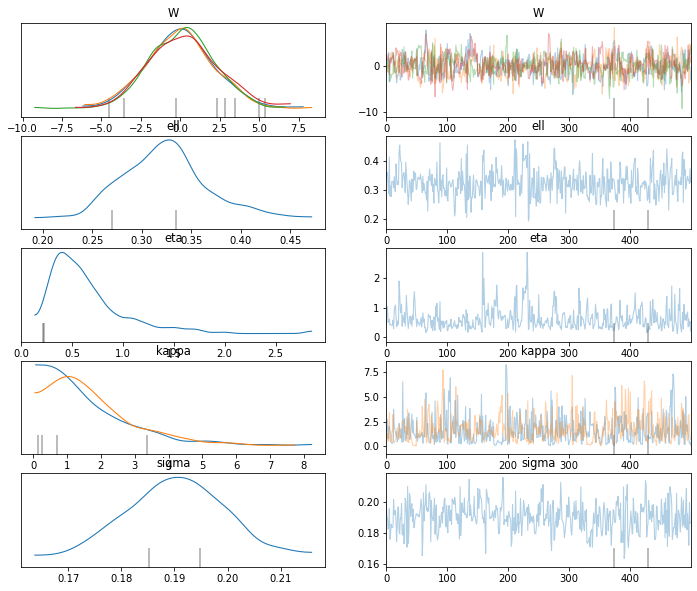

In [11]:
az.plot_trace(gp_trace);